# Ex. 4 Correspondence Analysis
##### Dan Schumacher

In [6]:
import pandas as pd
import prince  
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Latex,Image, display
from scipy.stats import chi2_contingency
import numpy as np

## 1. You are analyzing the relationship between race and pizza for women for a market research firm.

## Data Cleaning and Set Up

In [7]:
# load data, make sure na values are read
df = pd.read_csv('pizzafem truncated.csv', na_values=' ')

# rename the columns for my liking
df.rename(columns = {'myid':'id','RESP_RACE': 'race'}, inplace=True)

#remove missing values
df = df.dropna()

#convert floats to integers for consistancy
df['pizza'] = df['pizza'].astype(int)

# I am just making up race mappings to help me think about this less abstractly
race_mapping = {
    1: 'white', 2: 'black', 3: 'asian', 4: 'other'
}

# same for pizza
pizza_mapping = {
    1: 'pizza_hut', 2: 'dominos', 3: 'papa_johns', 4: 'little_ceasers'
}

# apply the mapping 
df['race'] = df['race'].map(race_mapping)
df['pizza'] = df['pizza'].map(pizza_mapping)

## 2. Run a correspondence analysis on the data.   Then answer the following questions.

### a.	Show the contingency table. Examining the table, is it easy to see relationships between race categories and pizza restaurants using this table?  

In [8]:
# Frequency table (cross-tabulation)
freq_table = pd.crosstab(df['race'], df['pizza'])
freq_table

pizza  dominos  little_ceasers  papa_johns  pizza_hut
race                                                 
asian       33               7          13         27
black       76              67          30        103
other      165             139          32        100
white      508             476         238        560

### b.	Generate and show a table that shows the expected frequencies for each cell.

In [9]:
# row and column totals
row_totals = freq_table.sum(axis=1)
column_totals = freq_table.sum(axis=0)

# grand total
grand_total = row_totals.sum()

# expected frequencies
expected_freq = pd.DataFrame(
    [(row * column_totals) / grand_total for row in row_totals],
    index = freq_table.index,
    columns = freq_table.columns
)

expected_freq

pizza     dominos  little_ceasers  papa_johns   pizza_hut
race                                                     
asian   24.304584       21.414141    9.728050   24.553225
black   83.850816       73.878788   33.561772   84.708625
other  132.459984      116.707071   53.017871  133.815074
white  541.384615      477.000000  216.692308  546.923077

### c.	Generate and show a table that shows the chi square contribution to the total chi square for the table for each cell in the contingency table.  Which cell contributes the most to the total chi square?  Which cell contributes the least to the total chi square for the table?

In [10]:
dif_table = freq_table - expected_freq
dif_table

pizza    dominos  little_ceasers  papa_johns  pizza_hut
race                                                   
asian   8.695416      -14.414141    3.271950   2.446775
black  -7.850816       -6.878788   -3.561772  18.291375
other  32.540016       22.292929  -21.017871 -33.815074
white -33.384615       -1.000000   21.307692  13.076923

##### The Most
- asian / little_ceasors | **(9.702349)**
- other / papa_johns | **(8.332113)**

##### The Least
- white / little_ceasors | **(0.002096)**
- asian / pizza_hut      | **(0.243826)**

In [11]:
chisquare = ( ( freq_table - expected_freq ) **2 ) / expected_freq
chisquare

pizza   dominos  little_ceasers  papa_johns  pizza_hut
race                                                  
asian  3.110946        9.702349    1.100494   0.243826
black  0.735059        0.640478    0.377996   3.949709
other  7.993755        4.258308    8.332113   8.545070
white  2.058671        0.002096    2.095219   0.312669

### d.	Using the total chi square for the table, calculate the degrees of freedom for the total chi square, find the critical value in the chi square table for those degrees of freedom and state the total chi square for the table from part c above.  Can you reject the null hypothesis that there is no relationship between race and pizza restaurant?

- DF = ( `#r - 1` * `#c - 1`)
- r = 4,
- c = 4
- therfore DF = 9

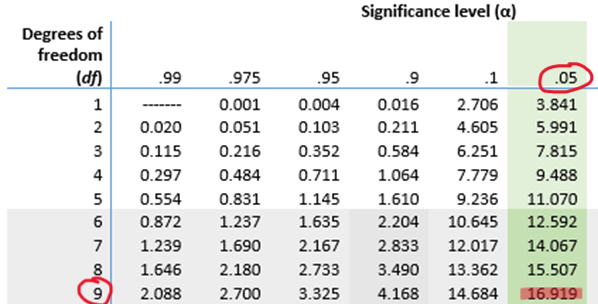

In [12]:
chi = 'chi-square.png'
# Display the chi-square table
display(Image(chi))

In [13]:
test_stat = chisquare.sum().sum()
critical_val = 16.919

if test_stat < critical_val:
    print('Do not reject H0: No relationship between pizza and race')
else:
    print('Reject H0, Accept Halt: A relationship exist between the pizza and race')

Reject H0, Accept Halt: A relationship exist between the pizza and race


In [14]:
# another way that scipy handels automatically
test_stat, p_val, degrees_freedom, arr = chi2_contingency(freq_table)

alpha = .05
if p_val > alpha:
    print('Do not reject H0: No relationship between pizza and race')
else:
    print('Reject H0, Accept Halt: A relationship exist between the pizza and race')

Reject H0, Accept Halt: A relationship exist between the pizza and race


### e.	Generate and show row and column tables for mass, inertia and quality.  Which row has the highest inertia?  Which column has the highest quality?

- The asian row has the highest inertia
- The papa_johns col has the highest quality

In [15]:
import prince

# Fitting the CA model
ca = prince.CA(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
).fit(freq_table)

# The row coordinates
row_coords = ca.row_coordinates(freq_table)

# The masses of the row points
row_masses = ca.row_masses_

# The contributions of the rows to the inertia
row_contributions = ca.row_contributions_

# Calculating quality for each row
total_inertia = ca.total_inertia_
row_quality = row_coords.apply(lambda x: (x**2).sum() / total_inertia, axis=1)

import pandas as pd

# Make sure that each component is a pandas Series
row_quality_series = pd.Series(row_quality, name='quality')
row_masses_series = pd.Series(row_masses, name='mass')
#row_contributions_series = pd.Series(row_contributions, name='inertia')

# Now, create the DataFrame
row_stats = pd.DataFrame({
    'quality': row_quality_series,
    'mass': row_masses_series,
    'inertia': row_contributions[0] +  row_contributions[1]
})

row_stats = pd.DataFrame(row_stats)
row_stats

quality      mass   inertia
asian  8.508775  0.031080  0.963716
black  0.436162  0.107226  0.071025
other  3.210988  0.169386  0.816968
white  0.103954  0.692308  0.148291

In [16]:
import prince

# The row coordinates
col_coords = ca.column_coordinates(freq_table)

# The masses of the row points
col_masses = ca.col_masses_

# The contributions of the rows to the inertia
col_contributions = ca.column_contributions_

# Calculating quality for each row
total_inertia = ca.total_inertia_
col_quality = col_coords.apply(lambda x: (x**2).sum() / total_inertia, axis=1)

# Make sure that each component is a pandas Series
col_quality_series = pd.Series(col_quality, name='quality')
col_masses_series = pd.Series(col_masses, name='mass')
#row_contributions_series = pd.Series(row_contributions, name='inertia')

# Now, create the DataFrame
col_stats = pd.DataFrame({
    'quality': col_quality_series,
    'mass': col_masses_series,
    'inertia': col_contributions[0] +  col_contributions[1]
})

col_stats = pd.DataFrame(col_stats)
col_stats

quality      mass   inertia
dominos         0.855753  0.303807  0.696192
little_ceasers  1.016442  0.267677  0.717370
papa_johns      1.462810  0.121601  0.263541
pizza_hut       0.707509  0.306915  0.322897

### f.	Generate and show the correspondence map for this analysis.  What proportion of the variance does dimension 1 explain?  What proportion of the variance does dimension 2 explain?

In [17]:
print(f'Dimension 1 explains {ca.percentage_of_variance_[0]:.2f}% of the variance.')
print(f'Dimension 2 explains {ca.percentage_of_variance_[1]:.2f}% of the variance.')
print(f'Together they explain {ca.percentage_of_variance_[0] + ca.percentage_of_variance_[1]:.2f}% of the variance')

Dimension 1 explains 67.96% of the variance.
Dimension 2 explains 24.75% of the variance.
Together they explain 92.71% of the variance


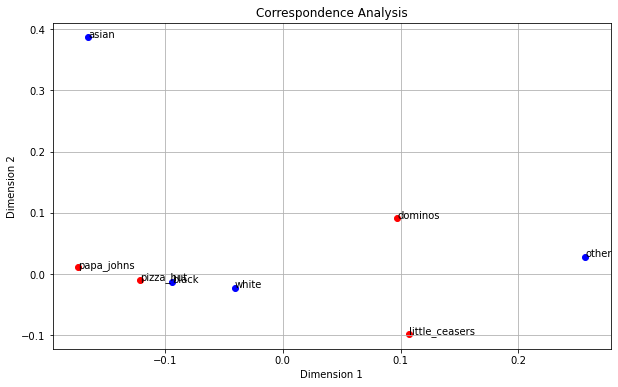

In [18]:
# Get row and column coordinates
row_coordinates = ca.row_coordinates(freq_table)
column_coordinates = ca.column_coordinates(freq_table)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Rows
for i, label in enumerate(row_coordinates.index):
    ax.scatter(
        row_coordinates[0][i],
        row_coordinates[1][i],
        color='blue'
    )
    
    ax.text(
        row_coordinates[0][i],
        row_coordinates[1][i],
        label
    )

# Columns
for i, label in enumerate(column_coordinates.index):
    ax.scatter(
        column_coordinates[0][i],
        column_coordinates[1][i],
        color='red'
    )
    
    ax.text(
        column_coordinates[0][i],
        column_coordinates[1][i],
        label
    )

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Correspondence Analysis')
plt.grid(True)
plt.show()

### g.	Find an example in the correspondence plot where the angle between row and column values suggests a strong association – draw the lines from the origin to these two points on the plot.

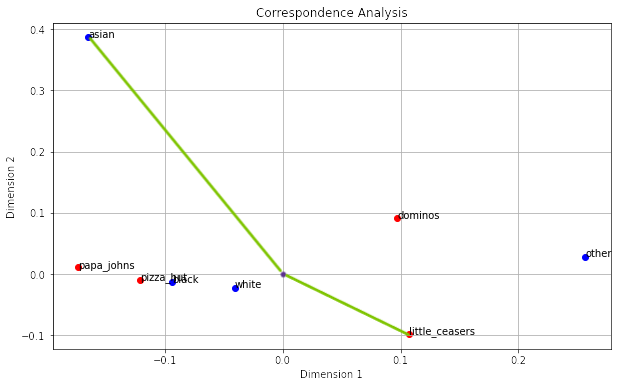

In [19]:
markedup = 'plotplot.png'
# Display the chi-square table
display(Image(markedup))

### h.	Generate and show the standardized adjusted residuals for each of the cells in the contingency table.  Which of these cells passes the test suggested by Sharpe for contributing significantly to the total chi square?

In [20]:
# to make readability
obs = freq_table
exp = expected_freq

# avoid div by 0
exp[exp == 0] = np.nan

# row/ col rows for prop
row_totals = freq_table.sum(axis=1)
column_totals = freq_table.sum(axis=0)

# all counts
grand_total = freq_table.values.sum()\

# props
row_prop = np.array(row_totals / grand_total)
col_prop = np.array(column_totals / grand_total)

# big ugly calc
std_res = (obs - exp)/ (np.sqrt(exp * ( 1 - row_prop) * (1- col_prop)))

#show it
std_res

pizza   dominos  little_ceasers  papa_johns  pizza_hut
race                                                  
asian  2.147522       -3.852266    1.228141   1.069272
black -1.043885       -0.989760   -0.719777   4.303592
other  3.442443        2.552092   -3.379341  -6.330038
white -1.746967       -0.056626    1.694607   1.210852

- the following cells pass the test suggested by Sharpe 
- we want the abs_val of the std residual to be greater than 2.

In [23]:
import numpy as np
#show it
np.abs(std_res) > 2

pizza  dominos  little_ceasers  papa_johns  pizza_hut
race                                                 
asian     True            True       False      False
black    False           False       False       True
other     True            True        True       True
white    False           False       False      False